In [1]:
import os
from pathlib import Path

from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import cv2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

import config as cfg

/home/shung/miniconda3/envs/STAS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
OUTPUT_PATH = "./OpenVINO"
BASE_MODEL_NAME = OUTPUT_PATH + "/Deeplabv3P_resnet50_batch16"

IMAGE_WIDTH = 1600
IMAGE_HEIGHT = 800
DEVICE='cuda'

In [3]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

# Paths where PyTorch, ONNX and OpenVINO IR models will be stored.
model_path = Path(BASE_MODEL_NAME).with_suffix(".pth")
onnx_path = model_path.with_suffix(".onnx")
ir_path = model_path.with_suffix(".xml")

In [4]:
def normalize(image: np.ndarray, input_range=[0, 1], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) -> np.ndarray:
    # image = image.astype(np.float32)
    if input_range is not None:
        if image.max() > 1 and input_range[1] == 1:
            image = image / 255.0

    if mean is not None:
        mean = np.array(mean)
        image = image - mean

    if std is not None:
        std = np.array(std)
        image = image / std
    return image

In [5]:
def preprocess_image(filename=None, num_randoms=10):
    def preprocess(filename):
        image_filename = os.path.join(cfg.INFERENCE_IMAGE_DIR, filename)
        image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

        resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_image = normalize(resized_image)

        # Convert the resized images to network input shape.
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0).astype(float)
        normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0).astype(float)
        return resized_image, normalized_input_image
    
    if filename != None:
        return preprocess(filename)
    
    import random
    inference_images = os.listdir(cfg.INFERENCE_IMAGE_DIR)
    
    random_images = random.sample(inference_images, num_randoms)
    resized_images, normalized_images = [], []
    for img_name in random_images:
        r_img, norm_img = preprocess(img_name)
        resized_images.append(r_img)
        normalized_images.append(norm_img)
    
    return resized_images, normalized_images

In [6]:
def convert_image_shape_to_show(inputs):
    outputs = np.zeros((800, 1600, 3))
    outputs[...,0] = inputs
    outputs[...,1] = inputs
    outputs[...,2] = inputs
    outputs = cv2.resize(outputs, (1716, 942))
    return outputs

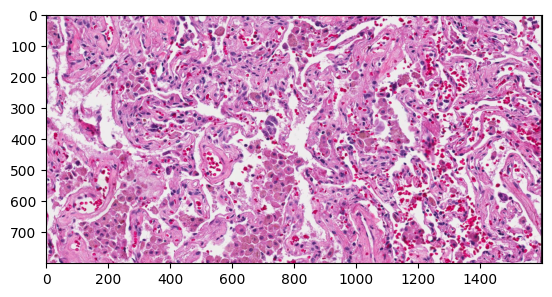

In [7]:
resized_image, normalized_image = preprocess_image("Private_00000045.jpg")
plt.imshow(resized_image)

# Load the OpenVINO IR Network and Run Inference on the ONNX model

In [8]:
from openvino.runtime import Core

In [9]:
ie = Core()
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: 12th Gen Intel(R) Core(TM) i7-12700


In [10]:

# Load the network to OpenVINO Runtime.
def load_openvino_model():
    ie = Core()
    model_onnx = ie.read_model(model=onnx_path)
    compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")
    return compiled_model_onnx

In [11]:
def inference(compiled_model_onnx, normalized_image):
    output_layer_onnx = compiled_model_onnx.output(0)
    # Run inference on the input image.
    res_onnx = compiled_model_onnx([normalized_image])[output_layer_onnx]
    # Convert the network result to a segmentation map and display the result.
    # result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1)).astype(np.uint8)
    
    res_onnx = np.squeeze(res_onnx).round()
    outputs = convert_image_shape_to_show(res_onnx)
    
    return outputs

True

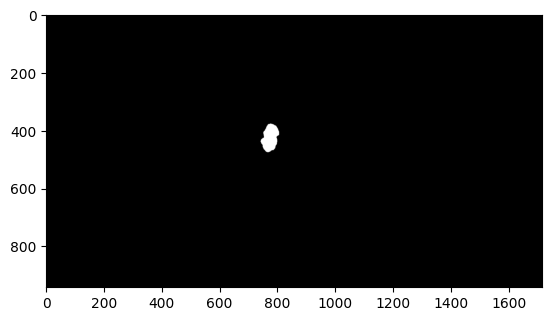

In [12]:
compiled_model_onnx = load_openvino_model()
outputs = inference(compiled_model_onnx, normalized_image)
plt.imshow(outputs)
cv2.imwrite("result.jpg", outputs)

# torch output

In [13]:
def torch_inference(best_model, normalized_image):
    best_model.eval()
    x_tensor = torch.from_numpy(normalized_image).to(DEVICE)

    with torch.no_grad():
        pr_mask = best_model(x_tensor.float())
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    mask = convert_image_shape_to_show(pr_mask)
    return mask

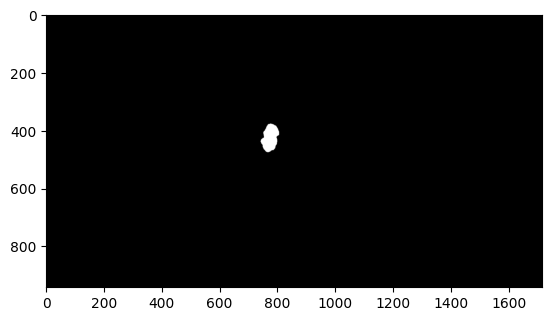

In [14]:
best_model = torch.load(os.path.join(cfg.MODEL_DIR, "Deeplabv3P_resnet50_batch16.pth"))
mask = torch_inference(best_model, normalized_image)
plt.figure()
plt.imshow(mask)

# Other Samples

In [15]:
resized_images, normalized_input_images = preprocess_image(num_randoms=10)

/tmp/ipykernel_1871/1819944347.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


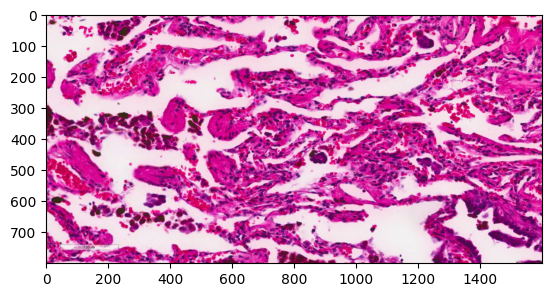

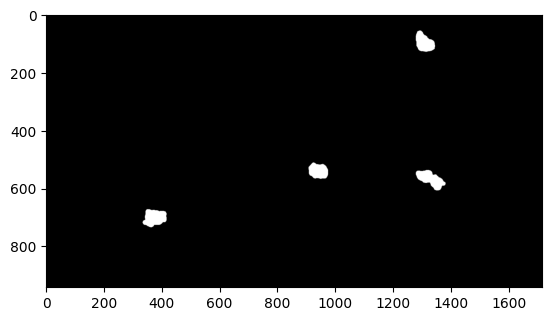

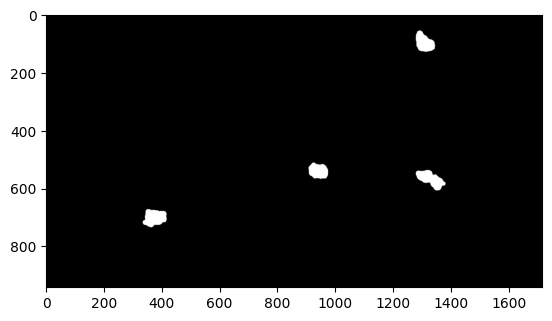

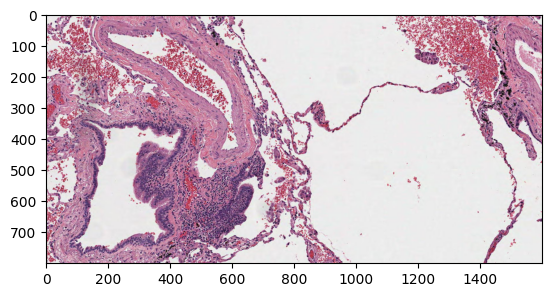

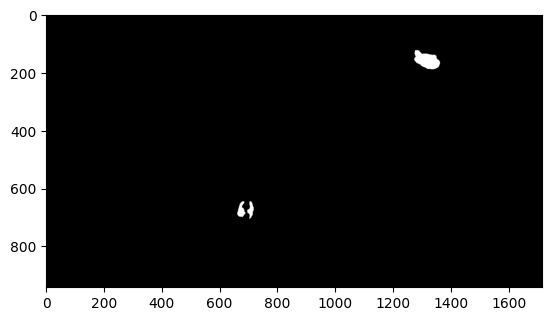

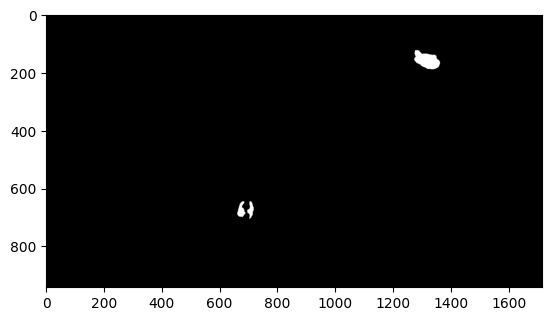

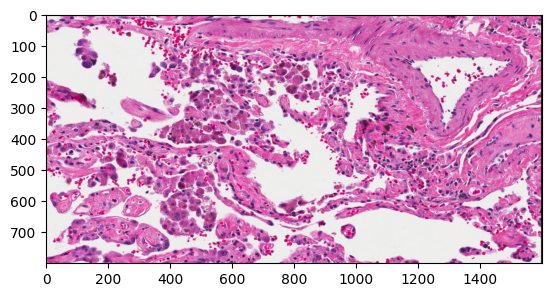

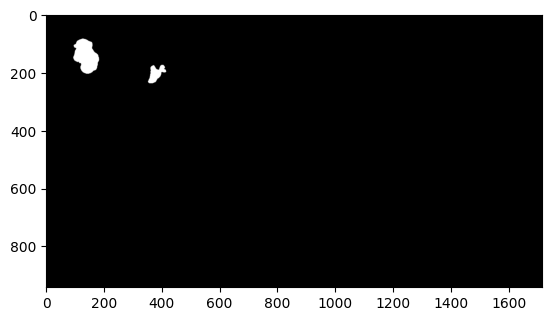

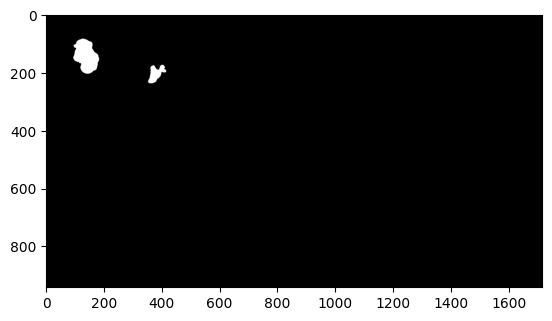

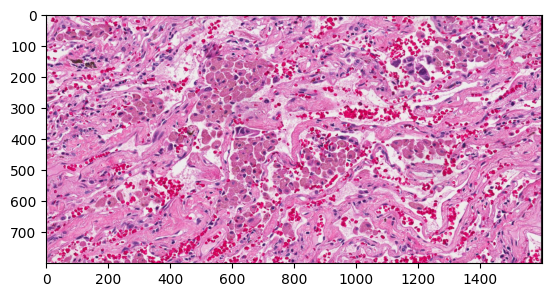

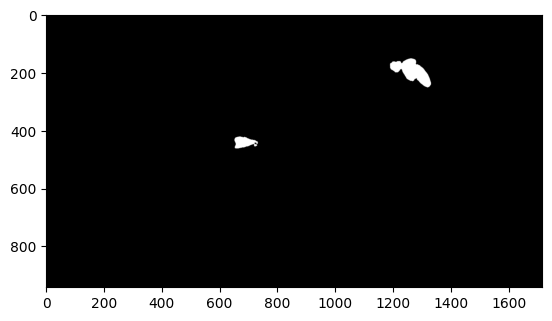

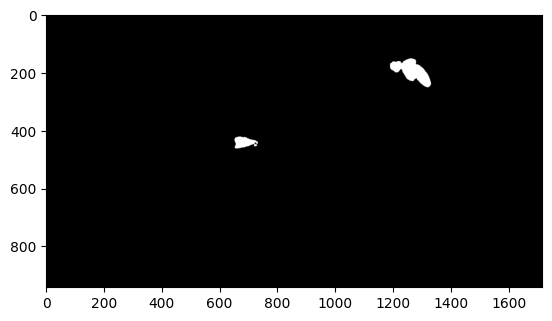

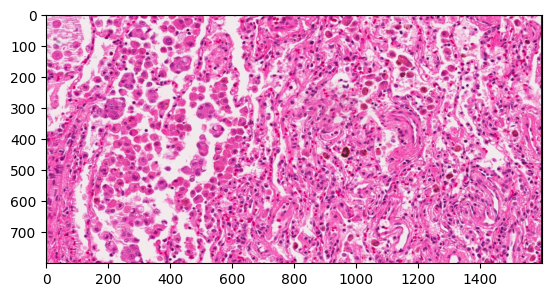

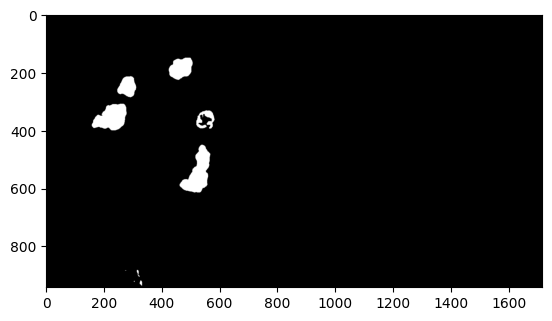

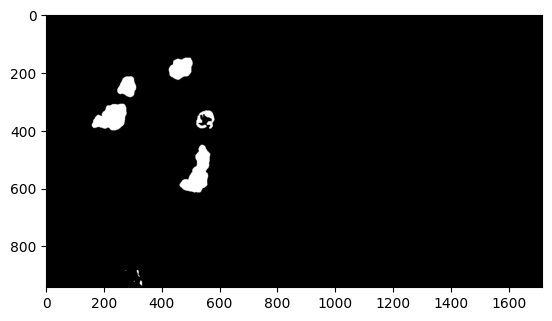

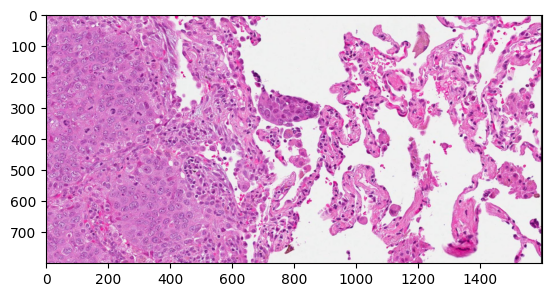

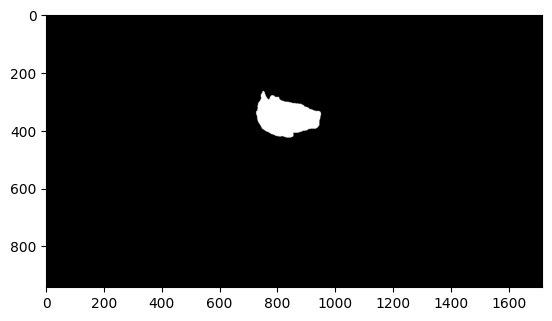

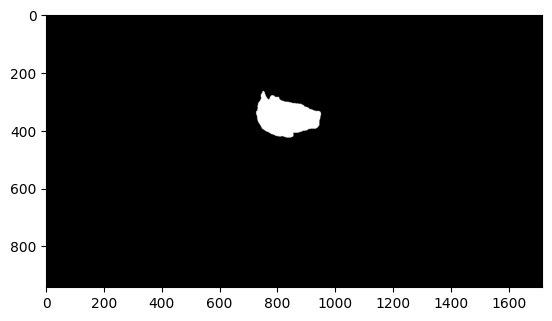

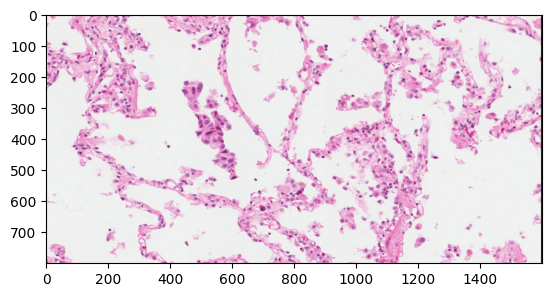

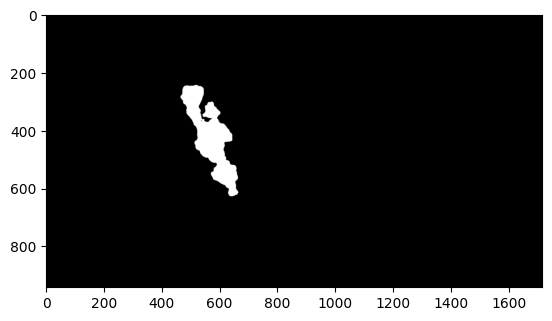

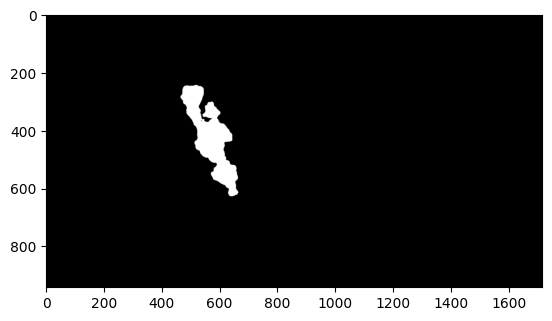

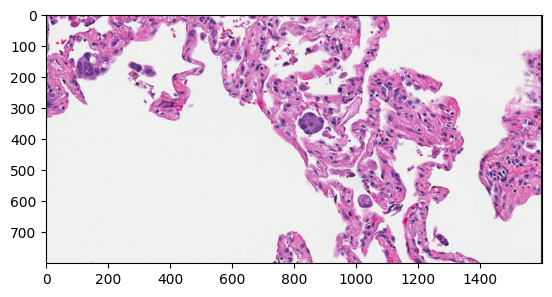

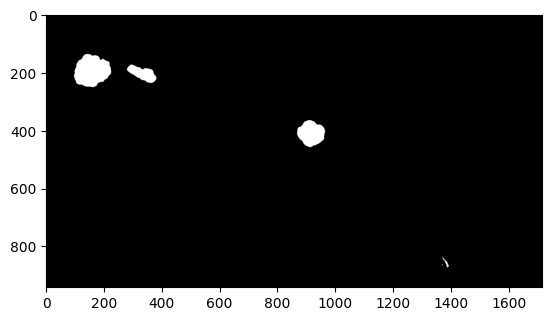

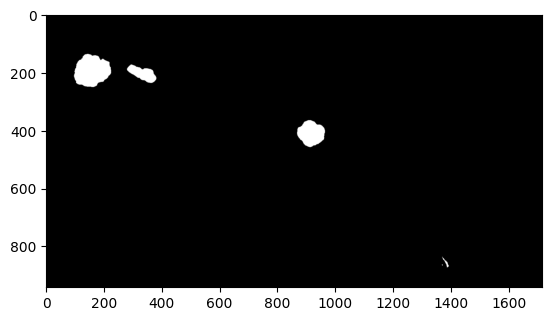

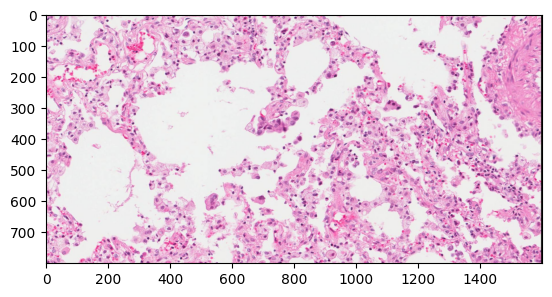

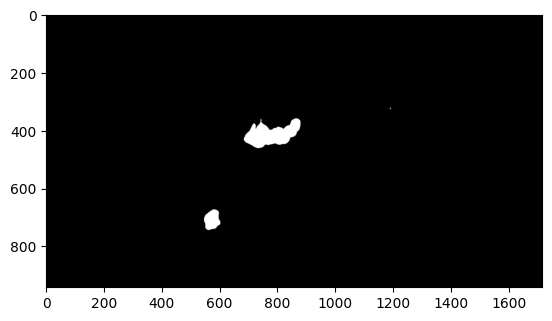

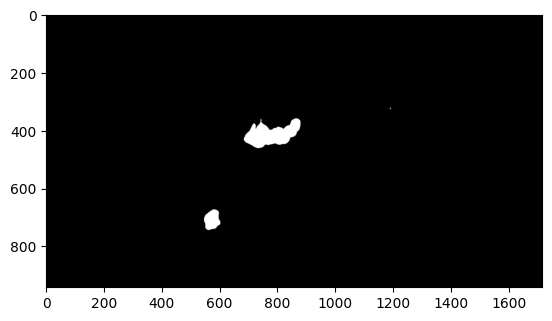

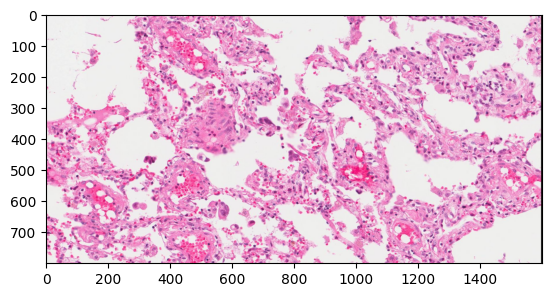

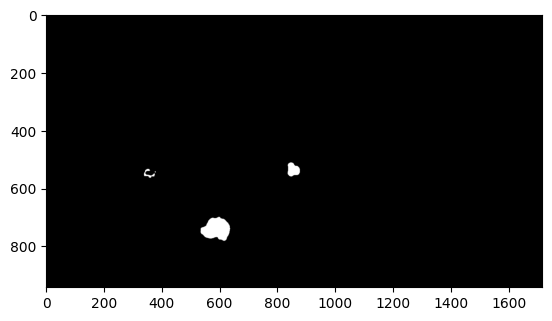

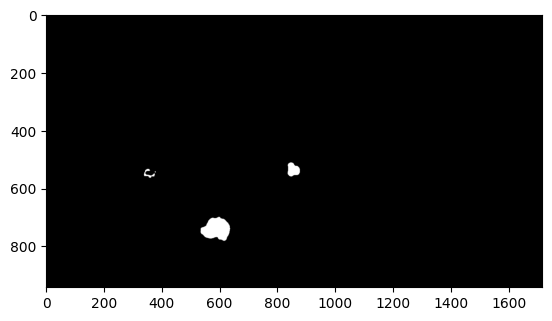

In [16]:
compiled_model_onnx = load_openvino_model()
best_model = torch.load(os.path.join(cfg.MODEL_DIR, "Deeplabv3P_resnet50_batch16.pth"))

for r_img, norm_img in zip(resized_images, normalized_input_images):
    plt.figure()
    plt.imshow(r_img)
    openvino_mask = inference(compiled_model_onnx, norm_img)
    plt.figure()
    plt.imshow(openvino_mask)
    torch_mask = torch_inference(best_model, norm_img)
    plt.figure()
    plt.imshow(torch_mask)